# Data cleaning

This notebook shows all the data cleaning steps. It has to be run once to obtain the cleaned data.

### Movie data 
<b>Why 3 datasets ?</b> \
For our purpose, we need movie data and corresponding movie plots. We will restrict the analysis to American movies, leaving us with approximately half of the original dataset — 20,788 movies. \\
Since we will try to assess the correlation of the data with historical events, the release date is really important. We want to have the precise date, not just the year. However, dropping all rows where the date is not precise will cause us to lose a lot of data, as only 13,335 movies have precise dates. This is where the Kaggle dataset comes in. When the date is not precise, we will try to match the movie with this dataset and extract its date. Using this method, we recover a lot of data and end up with 17,077 movies.

<b>Data preprocessing steps</b> \
We will apply the following pipeline:

<ul>
    <li>load CMU, plots and Kaggle datasets </li>
    <li>CMU data preprocessing</li><ul>
        <li>Remove unnecessary columns</li>
        <li>Check for NaN values in plots</li>
        <li>Merge CMU metadata and plots on Wikipedia ID — take only movies present in both</li>
        <li>Convert plots to lowercase</li>
        <li>Put each column of the movie metadata in the correct format. For example, {"/m/09c7w0": "United States of America"} should become "United States of America"</li>
        <li>Keep only American movies</li>
    </ul>
    <li>Kaggle data preprocessing</li><ul>
        <li>Remove unnecessary columns</li>
        <li>Put each column of the movie metadata in the correct format. For example, {"/m/09c7w0": "United States of America"} should become "United States of America"</li>
        <li>Keep only American movies</li>
        <li>Drop NaN values and duplicated rows (if present)</li>
    </ul>
    <li>For incomplete or missing dates, merge with the Kaggle dataset using the movie title, and ultimately the date</li>
    <li>Check for outliers (e.g., incorrect dates)</li>
    <li>Save the cleaned dataset</li>
</ul>


### Labelled data

For your project, we needed to assign to each movie a violence level. We therefore performed a human-labelling steps to create a training/validation set. This data also need to be cleaned.

<b>Data preprocessing steps</b> \
We will apply the following pipeline:

<ul>
    <li>load The data</li>
    <li>Assess the subjectivity of the data</li>
    <li>Make each label unique</li>
    <li>Save the data</li>
</ul>

## Imports

In [1]:
import sys
import os
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
# Add the project root directory (not src) to sys.path
sys.path.append(os.path.abspath("../data/"))

# Now import the DataLoader class
from data_loading import DataLoader

raw = '../../data/RAW/'
clean = '../../data/CLEAN'

# Movie data

## Load the data

In [3]:
#loader
data_loader = DataLoader(raw,clean)
#load raw data
CMU_movie_metadata,CMU_plot_summary,GVD_data,Kaggle_movies_metadata = data_loader.load_all_data()


load CMU movie metadata


load plot data


load GVD data


load kaggle movie data



## CMU metadata and plot data

In [4]:
CMU_movie_metadata

,Freebase movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"


In [5]:
CMU_plot_summary

,Plot
Wikipedia movie ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...
...,...
34808485,"The story is about Reema , a young Muslim scho..."
1096473,"In 1928 Hollywood, director Leo Andreyev look..."
35102018,American Luthier focuses on Randy Parsons’ tra...


In [6]:
#drop unnecessary columns in metadata
CMU_movie_metadata.drop(['Freebase movie ID', 'Runtime'], axis=1,inplace=True)

In [7]:
#check for NAN
CMU_plot_summary[CMU_plot_summary["Plot"].isna()]

,Plot
Wikipedia movie ID,


In [8]:
#merge the two datasets
Movie_Data = CMU_movie_metadata.merge(CMU_plot_summary,left_index=True, right_index=True, how='inner')

In [9]:
# Lower case the plot_summaries
Movie_Data['Plot'] = Movie_Data['Plot'].str.lower()

In [10]:
# put genres, countries and languages in an understandable format
def extract_data(text):
    # Find all matches for names using a regex pattern that matches quoted text after colon
    return ', '.join(re.findall(r'": "([^"]+)"', text))

for name in ['Genres','Countries','Languages'] :
    Movie_Data[name] = Movie_Data[name].apply(extract_data)

In [11]:
Movie_Data["Countries"].value_counts() #majority of american movies

Countries
United States of America                                             17774
India                                                                 4628
                                                                      3312
United Kingdom                                                        2284
Japan                                                                 1157
                                                                     ...  
Slovakia, Austria, Greece, Spain                                         1
United States of America, Sweden, United Kingdom, Germany                1
Federal Republic of Yugoslavia                                           1
France, United Kingdom, Sweden                                           1
Kingdom of Great Britain, Japan, England, United Kingdom, Germany        1
Name: count, Length: 1501, dtype: int64

In [12]:
# only american movies
Movie_Data = Movie_Data[Movie_Data['Countries'].str.contains("United States of America", na=False)]
Movie_Data.shape

(20788, 7)

In [13]:
#shape before any drop for dates
Movie_Data.shape

(20788, 7)

In [14]:
#find all movies where the date format is wrong
Movie_Data_date_wrong = Movie_Data[~Movie_Data['Release date'].str.match(r'^\d{4}-\d{2}-\d{2}$', na=False)]

In [15]:
# number of remaining datapoint if we drop all row where the date format is wrong
Movie_Data.shape[0]-Movie_Data_date_wrong.shape[0]

13335

## Kaggle metadata

In [16]:
Kaggle_movies_metadata

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [17]:
Kaggle_movies_metadata = Kaggle_movies_metadata[["production_countries","release_date","title"]]

In [18]:
# majority from US
Kaggle_movies_metadata['production_countries'].value_counts()

production_countries
[{'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                                          17851
[]                                                                                                                                                                   6282
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]                                                                                                                     2238
[{'iso_3166_1': 'FR', 'name': 'France'}]                                                                                                                             1654
[{'iso_3166_1': 'JP', 'name': 'Japan'}]                                                                                                                              1356
                                                                                                                                 

In [19]:
# extract country of production for the kaggle dataset
def extract_country(text):
    final_countries = ""
    countries = ast.literal_eval(Kaggle_movies_metadata.production_countries[0])
    for country in countries :
        final_countries = final_countries + " " + country['name']
    return final_countries 

Kaggle_movies_metadata.loc[:, 'production_countries'] = Kaggle_movies_metadata['production_countries'].apply(extract_country)

In [20]:
# only american movies
Kaggle_movies_metadata = Kaggle_movies_metadata[Kaggle_movies_metadata['production_countries'].str.contains("United States of America", na=False)]
Kaggle_movies_metadata.shape

(45466, 3)

In [21]:
# drop NAN
Kaggle_movies_metadata.dropna(inplace=True)
Kaggle_movies_metadata.shape

(45376, 3)

In [22]:
# drop full duplicates
Kaggle_movies_metadata.drop_duplicates()
Kaggle_movies_metadata.shape

(45376, 3)

## Handle the movie name duplicate and the date problem

In [23]:
Movie_Data[Movie_Data["Movie name"] == "Dr. Jekyll and Mr. Hyde"]

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
7884497,Dr. Jekyll and Mr. Hyde,1913-03-06,NaN,English Language,United States of America,"Short Film, Science Fiction, Horror, Black-and...","dr. henry jekyll sends a note to his fiancée,..."
7883633,Dr. Jekyll and Mr. Hyde,1920-04,NaN,"Silent film, English Language",United States of America,"Silent film, Horror, Indie, Science Fiction, B...",at the first transformation starts with jekyll...
144774,Dr. Jekyll and Mr. Hyde,1931-12-31,NaN,English Language,United States of America,"Science Fiction, Horror, Black-and-white, Dram...","the film tells the story of dr. henry jekyll ,..."
3672796,Dr. Jekyll and Mr. Hyde,1920-03-18,NaN,"Silent film, English Language",United States of America,"Crime Fiction, Silent film, Horror, Science Fi...","henry jekyll is a doctor of medicine, but he ..."
2490751,Dr. Jekyll and Mr. Hyde,1941-08-12,1279000.0,English Language,United States of America,"Science Fiction, Horror, Black-and-white",dr. jekyll believes good and evil exist in ev...
7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,NaN,Silent film,United States of America,"Short Film, Silent film, Horror, Indie, Black-...",dr. jekyll and mr. hyde began with the raising...
7856323,Dr. Jekyll and Mr. Hyde,1912-01-16,NaN,English Language,United States of America,"Short Film, Horror, Black-and-white",james cruze's white-haired dr. jekyll has secr...


In [24]:
Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == "Dr. Jekyll and Mr. Hyde"]

,production_countries,release_date,title
7055,United States of America,1941-08-12,Dr. Jekyll and Mr. Hyde
7823,United States of America,1931-12-31,Dr. Jekyll and Mr. Hyde
8294,United States of America,1920-03-18,Dr. Jekyll and Mr. Hyde
25134,United States of America,2008-05-17,Dr. Jekyll and Mr. Hyde


as we can see, some nome are similar in both dataset, but there is no duplicate. They are different movies. 

We will take that into account for the date algorithm. 

In [25]:
#iter on all row of the wrong date dataset
for index, row in Movie_Data_date_wrong.iterrows() :
    # is it in the kaggle dataset ?
    kaggle_data = Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == row["Movie name"]]
    
    #if not, drop the row
    if kaggle_data.empty :
        #print("drop")
        Movie_Data.drop([index], inplace=True)

    #if yes and only ones, extract the date
    elif kaggle_data.shape[0] == 1 :
        #print("change")
        Movie_Data.loc[index,"Release date"] = kaggle_data.iloc[0]["release_date"]

    #if multiple movies have this name in the kaggle dataset, compare with the incomplete date of the CMU dataset
    else :
        date = Movie_Data_date_wrong.loc[index, "Release date"]

        #if not the same year and not the year in the CMU, drop
        if pd.isna(date) or len(date) < 4 :
            Movie_Data.drop([index],inplace=True)

        #else, compare
        else :
            kaggle_data = kaggle_data[kaggle_data['release_date'].str[:4] == date[0:4]]

            #found only 1 movie this year ? extract the date !
            if kaggle_data.shape[0] == 1 :
                #print("found!")
                Movie_Data.loc[index,"Release date"] = kaggle_data.iloc[0]["release_date"]

            #give up
            else :
                #print("sad..")
                Movie_Data.drop([index], inplace=True)

In [26]:
Movie_Data #nice we kept 4000 more data !!

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th..."
6631279,Little city,1997-04-04,NaN,English Language,United States of America,"Romantic comedy, Ensemble Film, Comedy-drama, ...","adam, a san francisco-based artist who works a..."
77856,Mary Poppins,1964-08-27,102272727.0,English Language,United States of America,"Children's/Family, Musical, Fantasy, Comedy, D...",the film opens with mary poppins perched in a...
21926710,White on Rice,2009-05-31,NaN,,United States of America,"Romantic comedy, Romance Film, Comedy, Indie",jimmy ([[hiroshi watanabe loves dinosaurs and...
156558,Baby Boy,2001-06-27,29381649.0,English Language,United States of America,"Crime Fiction, Drama, Coming of age",a young 20-year-old named jody lives with his...
...,...,...,...,...,...,...,...
25011340,Dot.Kill,2005-03-08,NaN,,United States of America,"Thriller, Crime Thriller, Action, Psychologica...","charlie daines , is a morphine-addicted detect..."
7761830,Spaced Invaders,1990-04-27,15369573.0,English Language,United States of America,"Alien Film, Science Fiction, Family Film, Come...","the space armada from mars, known as the imper..."
1918494,State and Main,2000-08-26,6944471.0,"Italian Language, English Language","France, United States of America","Parody, Americana, Comedy",havoc is wrought on the inhabitants of a small...


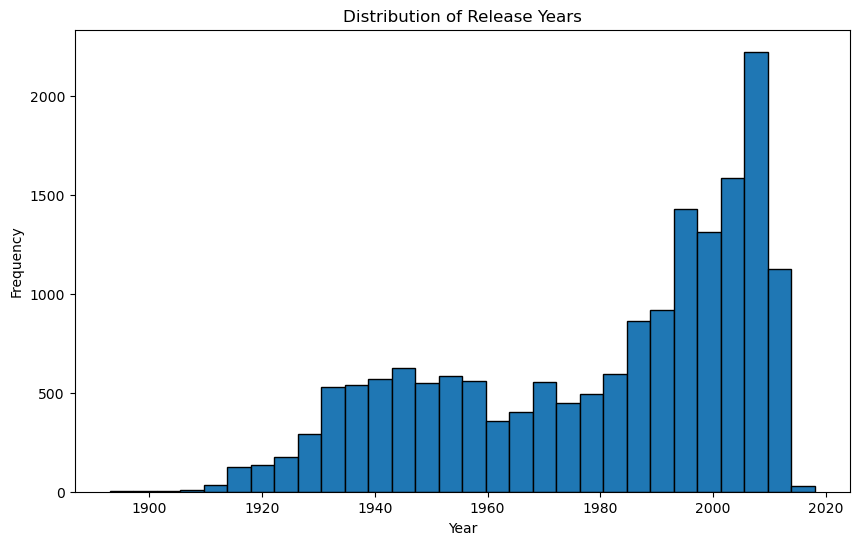

In [27]:
Date = Movie_Data["Release date"].str[:4].astype(int)
plt.figure(figsize=(10, 6))
plt.hist(Date, bins=30, edgecolor='black')
plt.title('Distribution of Release Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

#look nice ! no outliers :)

In [28]:
#save the data 
Movie_Data.to_csv(clean+"/Movie_Data_clean.tsv", sep="\t")

# Human Labelled data

## Data loading

In [29]:
#load the labelled data
ViolentLabel,ViolentData = data_loader.human_labelled_data("Raw")
display(ViolentLabel)
display(ViolentData.head())
# LAST is  boolean to recognize the point we added to help the analysis, more explanation after

,Violence level,Label
0,Peaceful,-1
1,Mild,0
2,Violent,1


,Answer,Date,LAST
Wikipedia movie ID,,,
19286405,0,11.11,0
6714641,1,11.11,0
27573594,1,11.11,0
25874731,0,11.11,0
34954266,-1,11.11,0


## Assess subjectivity and clean the data

Some data have been labelled several times by several people, to assess the subjectivity of the labelling task. \
Let's visualize the data.
Here we will plot only datapoint that have been labelled at least 2 times. 

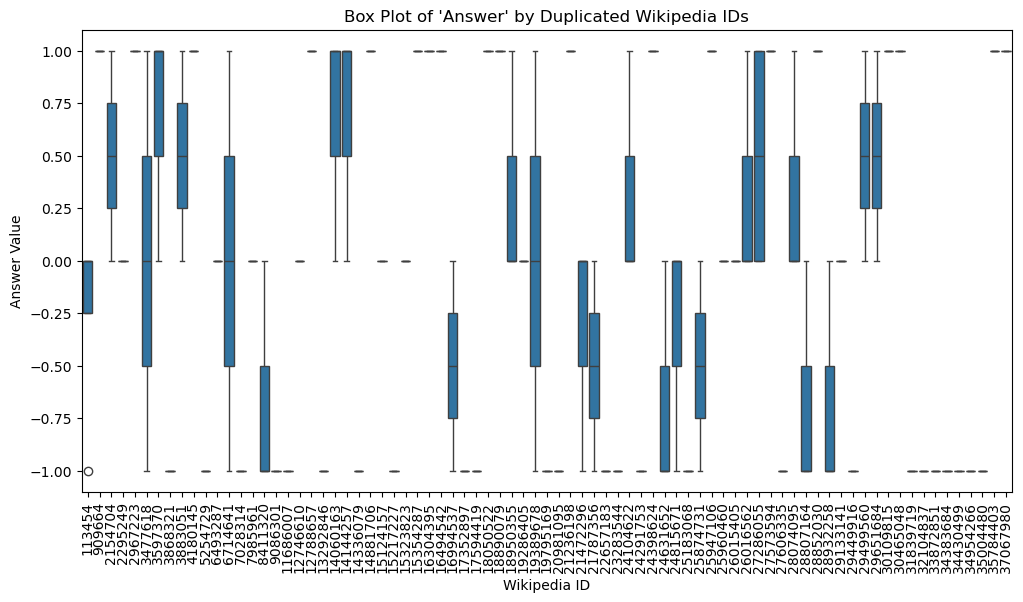

In [30]:
DataBefore = ViolentData[ViolentData["LAST"] == 0]
duplicated_data = DataBefore[DataBefore.index.duplicated(keep=False)]

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=duplicated_data, x="Wikipedia movie ID", y="Answer")

# Add labels and title
plt.title("Box Plot of 'Answer' by Duplicated Wikipedia IDs")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [31]:
print("We have",len(DataBefore.index.unique()),"labelled plots")
print("We have",len(duplicated_data.index.unique()),"duplicated labelling")
print("We have",(duplicated_data.groupby("Wikipedia movie ID")["Answer"].nunique() > 1).sum(),"datapoint with different labels")

We have 146 labelled plots
We have 79 duplicated labelling
We have 25 datapoint with different labels


In [32]:
DataBefore.groupby("Wikipedia movie ID").size().value_counts().sort_index()

1    67
2    40
3    36
4     2
6     1
Name: count, dtype: int64

The task is more difficult than expected ! \
A majority of duplicated labelling show the same output. However, we have different value for 24 points.
Additionnaly, for 3 points we have the 3 answers ! We will take a closer look to this point and to the point with opposite labels.

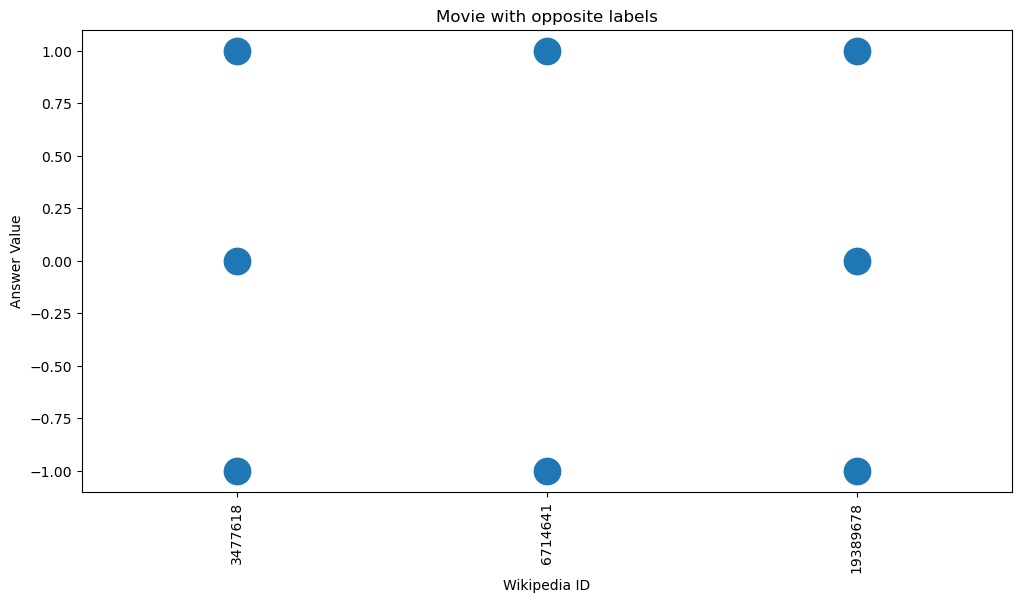

In [33]:
OppositeLabels = duplicated_data.groupby("Wikipedia movie ID").filter( lambda group: set([-1, 1]).issubset(group["Answer"].unique()))

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.swarmplot(data=OppositeLabels, x="Wikipedia movie ID", y="Answer", size=20)

# Add labels and title
plt.title("Movie with opposite labels")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [34]:
for plot in Movie_Data.loc[OppositeLabels.index.unique()]["Plot"] :
    display(plot)
    print("\n\n")

'after serving time for the attempted murder of his first wife, the main character, a doctor, begins plotting to kill his second.'

'a lewd old lady claiming to be mother goose has been put on trial for obscenity, and the evidence being presented is a collection of pornographic animated shorts. little red riding hood, jack of jack and the beanstalk fame, cinderella and snow white are among the most notable participants in what becomes an all out fairy tale orgy.'

'the gang tries to escape their babysitting chores by coercing spanky to mind their baby brothers and sisters while they go swimming. unfortunately, the infants would prefer to run  amok, forcing spanky to take desperate measures.<ref namehttp://movies.nytimes.com/movie/225666/forgotten-babies/overview |title2008-09-19|work=ny times}}'

We can distinguish 3 types of datapoints :
- have been labeled multiple times with always the same label : We keep this label.
- have been labeled multiple times with different labels but the mean is closer to 1 label (example 3 labels (0,0,1)) : we could keep the label closest to the mean, we will take a deep look and relabel if necessary.
- have been labeled multiple times with different labels and the mean is exactly between 2 labels : We will take a closer look and re-label by another person.

After relabelling, here is the result

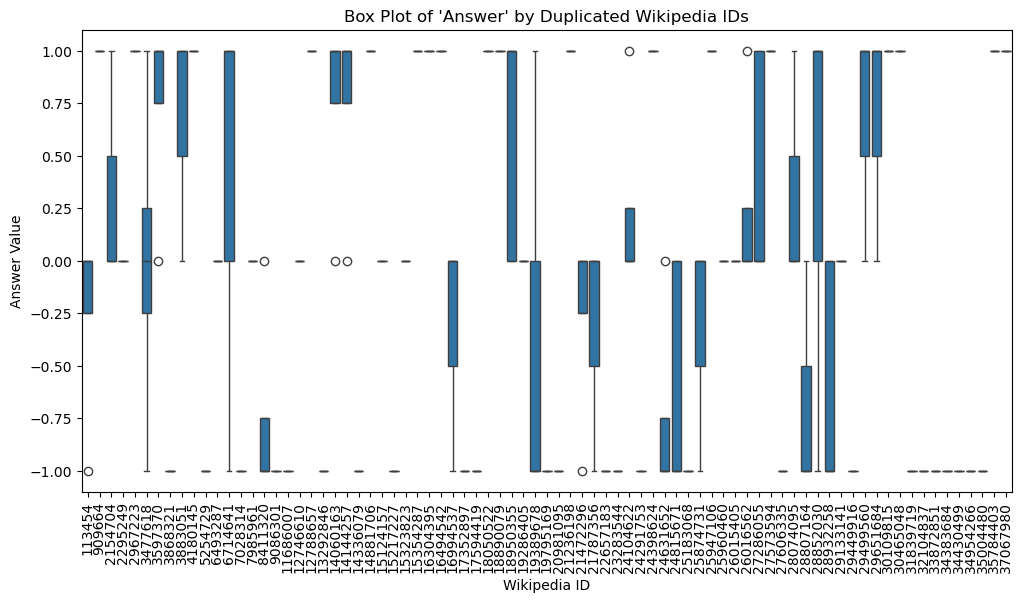

In [35]:
duplicated_data_clean = ViolentData[ViolentData.index.duplicated(keep=False)]

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=duplicated_data_clean, x="Wikipedia movie ID", y="Answer")

# Add labels and title
plt.title("Box Plot of 'Answer' by Duplicated Wikipedia IDs")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [36]:
ViolentData.groupby("Wikipedia movie ID").size().value_counts().sort_index()

1    67
2    31
3    32
4    11
5     4
7     1
Name: count, dtype: int64

In [37]:
FinalData = ViolentData.groupby("Wikipedia movie ID")["Answer"].median().to_frame()
FinalData.head()

,Answer
Wikipedia movie ID,
113454,0.0
909664,1.0
1028671,0.0
1336564,0.0
1472852,-1.0


In [38]:
FinalData[~FinalData["Answer"].isin([-1, 0, 1])]

,Answer
Wikipedia movie ID,


The labelling step is done ! We save the data.

In [39]:
data_loader.save_back_to_excel(ViolentLabel, FinalData)

# Historical data

## FBI NIBRS

Washington data was already merged in `Data_Merging_by_States_Year.ipynb` in order to have all reported incidents from all available years in the state of Washington.

To have better results, we would need to use and clean the data of each states.

In [ ]:
# Load the washington data
WA_data_example = pd.read_csv(raw+"/Washington/Washington_merged_data.csv", index_col=0)
WA_data_example

,incident_date,offense_type_id,arrestee_id,weapon_id,victim_id,injury_id,circumstances_id,year
incident_id,,,,,,,,
89222817,10-JUL-16,27,NaN,NaN,97453189,3.0,6.0,2016
89222827,10-AUG-16,21,NaN,NaN,97453202,NaN,NaN,2016
89222824,02-JUL-16,32,25962728.0,1.0,97453196,NaN,1.0,2016
89222840,28-NOV-16,45,25962737.0,1.0,97453219,NaN,NaN,2016
89222840,28-NOV-16,45,25962735.0,1.0,97453219,NaN,NaN,2016
...,...,...,...,...,...,...,...,...
47084911,2008-12-21 00:00:00,49,NaN,NaN,50924594,NaN,NaN,2008
47084912,2008-12-28 00:00:00,35,12637007.0,1.0,50924595,NaN,NaN,2008
47084913,2008-12-01 00:00:00,11,12637008.0,1.0,50924597,NaN,NaN,2008


In order to clean the data, we will use data that gives `offense_type`. To do so, we have to iterate through the years to get all offense types. We save the results in `offense_data`

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import importlib

sys.path.append(os.path.abspath("../data/"))

import FBI_merging

importlib.reload(FBI_merging)

from FBI_merging import merge_offense_types


offense_data = merge_offense_types('../../data/RAW/Washington', 'WA')

Loaded offense type data from: ../../data/RAW/Washington/WA-2016/nibrs_offense_type.csv
Loaded offense type data from: ../../data/RAW/Washington/WA-2011/nibrs_offense_type.csv
Loaded offense type data from: ../../data/RAW/Washington/WA-2018/nibrs_offense_type.csv
Loaded offense type data from: ../../data/RAW/Washington/WA-2020/nibrs_offense_type.csv
Loaded offense type data from: ../../data/RAW/Washington/WA-2019/nibrs_offense_type.csv
Loaded offense type data from: ../../data/RAW/Washington/WA-2010/nibrs_offense_type.csv
Loaded offense type data from: ../../data/RAW/Washington/WA-2017/nibrs_offense_type.csv
Loaded offense type data from: ../../data/RAW/Washington/WA-2005/nibrs_offense_type.csv
Loaded offense type data from: ../../data/RAW/Washington/WA-2012/nibrs_offense_type.csv
Loaded offense type data from: ../../data/RAW/Washington/WA-2015/nibrs_offense_type.csv
Loaded offense type data from: ../../data/RAW/Washington/WA-2014/nibrs_offense_type.csv
Loaded offense type data from: .

To clean a state data (in our example Washington), we have to keep only violent incidents. As a proof of concept, we will only focus on 2 parameters used in `offense_data`:
-  crime against a `Person`
-  violent categories found in `offense_category_name`

In [9]:
# Visualize offense_data
offense_data

,offense_type_id,offense_code,offense_name,crime_against,ct_flag,hc_flag,hc_code,offense_category_name,offense_group
0,58,23*,Not Specified,Property,N,Y,6.0,Larceny/Theft Offenses,A
1,1,09C,Justifiable Homicide,Person,N,N,NaN,Homicide Offenses,A
2,2,26A,False Pretenses/Swindle/Confidence Game,Property,Y,Y,NaN,Fraud Offenses,A
3,3,36B,Statutory Rape,Person,N,Y,NaN,Sex Offenses,A
4,4,11C,Sexual Assault With An Object,Person,N,Y,2.0,Sex Offenses,A
...,...,...,...,...,...,...,...,...,...
1085,60,64B,"Human Trafficking, Involuntary Servitude",Person,N,Y,NaN,Human Trafficking,NaN
1086,61,40C,Purchasing Prostitution,Society,N,Y,NaN,Prostitution Offenses,NaN
1087,63,26F,Identity Theft,Property,N,Y,NaN,Fraud Offenses,NaN
1088,64,26G,Hacking/Computer Invasion,Property,N,Y,NaN,Fraud Offenses,NaN


In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append(os.path.abspath("../data/"))

from FBI_cleaning import filter_violent_offenses

# Example of violent categories and targets used in filter_violent_offenses
# violent_categories = [
#         "Assault Offenses", "Homicide Offenses", "Sex Offenses", "Kidnapping/Abduction", "Animal Cruelty"]
#     violent_targets = ["Person"]  # Offenses against a person

# Clean the data by filtering out non-violent offenses
WA_cleaned_data = filter_violent_offenses(WA_data_example, offense_data)

# Save the cleaned data
state_clean_dir = '../../data/CLEAN/'
output_file = os.path.join(state_clean_dir, 'Washington_cleaned_data.csv')

WA_cleaned_data.to_csv(output_file, index=False)

Identified 288 violent offense types.
Dropped 4382917 non-violent rows. Remaining rows: 861479


In [12]:
WA_cleaned_data

,incident_date,offense_type_id,arrestee_id,weapon_id,victim_id,injury_id,circumstances_id,year
incident_id,,,,,,,,
89222817,10-JUL-16,27,NaN,NaN,97453189,3.0,6.0,2016
89222824,02-JUL-16,32,25962728.0,1.0,97453196,NaN,1.0,2016
88680735,13-DEC-16,27,25768014.0,1.0,96830515,4.0,NaN,2016
88680735,13-DEC-16,27,25768014.0,1.0,96830512,4.0,2.0,2016
88680735,13-DEC-16,27,25768014.0,1.0,96830512,1.0,2.0,2016
...,...,...,...,...,...,...,...,...
47084228,2008-12-10 00:00:00,27,12636919.0,1.0,50922935,1.0,1.0,2008
47084901,2008-12-07 00:00:00,51,NaN,NaN,50923874,4.0,NaN,2008
47084904,2008-12-09 00:00:00,51,12637003.0,1.0,50923877,4.0,NaN,2008


#### Before data cleaning

/Users/lucie/ADA MA1/ada-2024-project-alligatorsdontapologize24/src/plots_helper/FBI_analysis.py:119: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[date_column] = pd.to_datetime(data[date_column], errors='coerce')


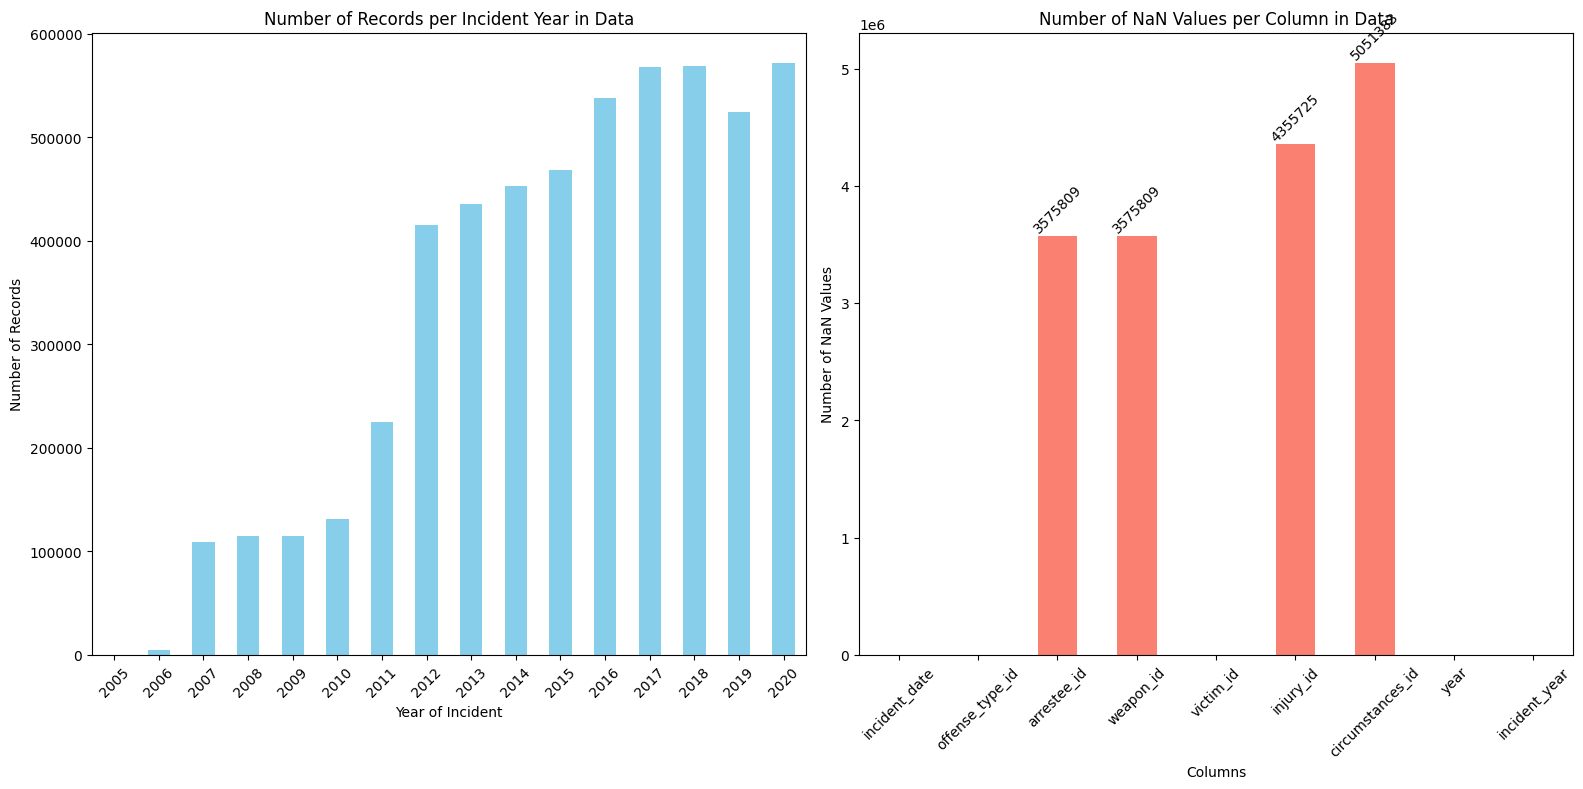

In [18]:
import os
import pandas as pd
import sys
import importlib

sys.path.append(os.path.abspath("../plots_helper/"))

import FBI_analysis

importlib.reload(FBI_analysis)

from FBI_analysis import analyze_incidents_and_missing_values

# Analyze and visualize the incidents and missing values per column
analyze_incidents_and_missing_values(WA_data_example, 'incident_date', verbose=False)

#### After data cleaning

/Users/lucie/ADA MA1/ada-2024-project-alligatorsdontapologize24/src/plots_helper/FBI_analysis.py:119: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[date_column] = pd.to_datetime(data[date_column], errors='coerce')
/Users/lucie/ADA MA1/ada-2024-project-alligatorsdontapologize24/src/plots_helper/FBI_analysis.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_column] = pd.to_datetime(data[date_column], errors='coerce')
/Users/lucie/ADA MA1/ada-2024-project-alligatorsdontapologize24/src/plots_helper/FBI_analysis.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

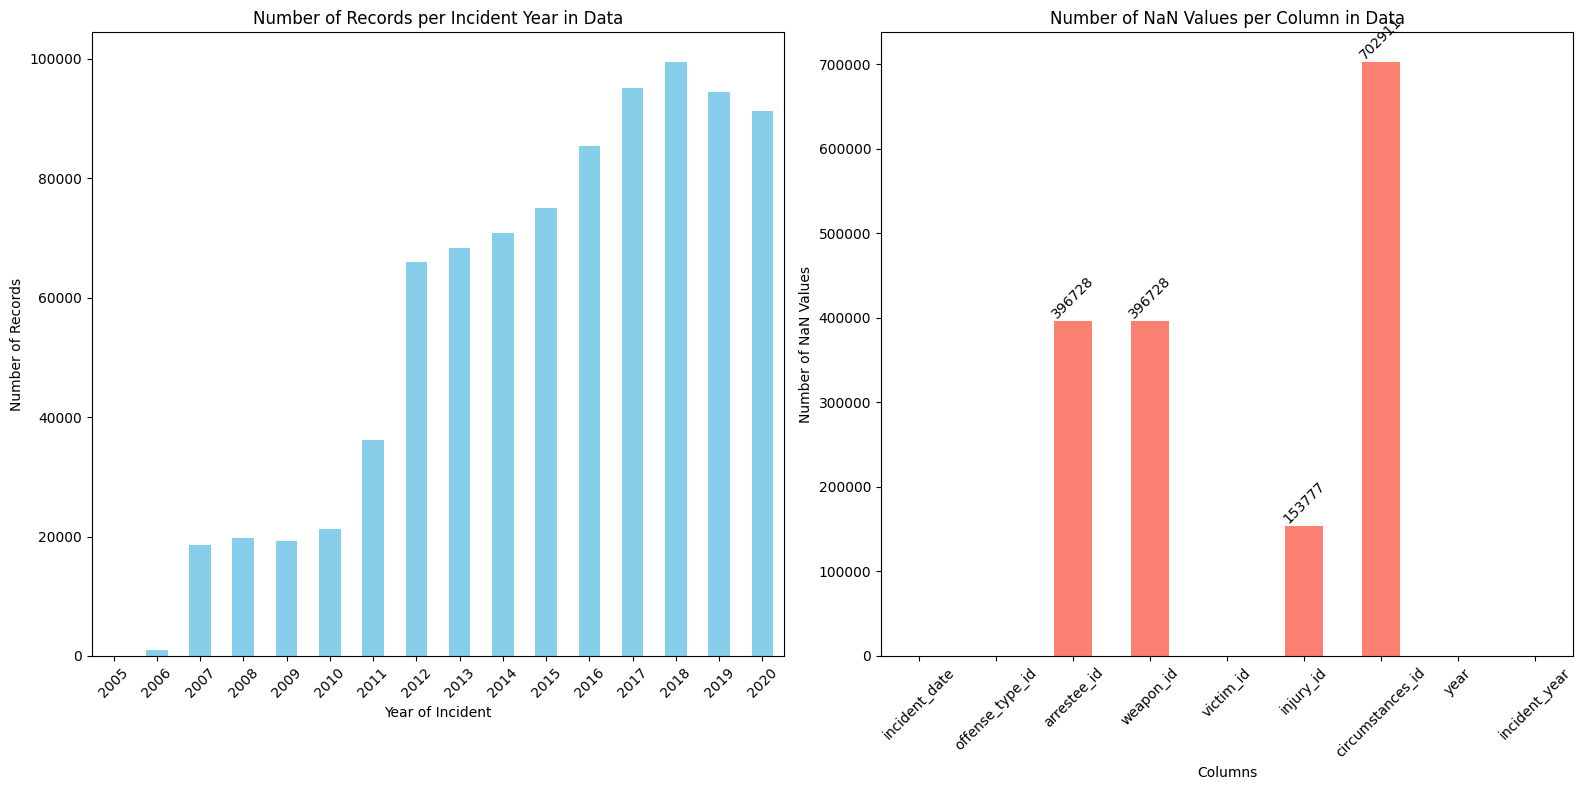

In [19]:
import os
import pandas as pd
import sys
import importlib

sys.path.append(os.path.abspath("../plots_helper/"))

import FBI_analysis

importlib.reload(FBI_analysis)

from FBI_analysis import analyze_incidents_and_missing_values

# Analyze and visualize the incidents and missing values per column
analyze_incidents_and_missing_values(WA_cleaned_data, 'incident_date', verbose=False)

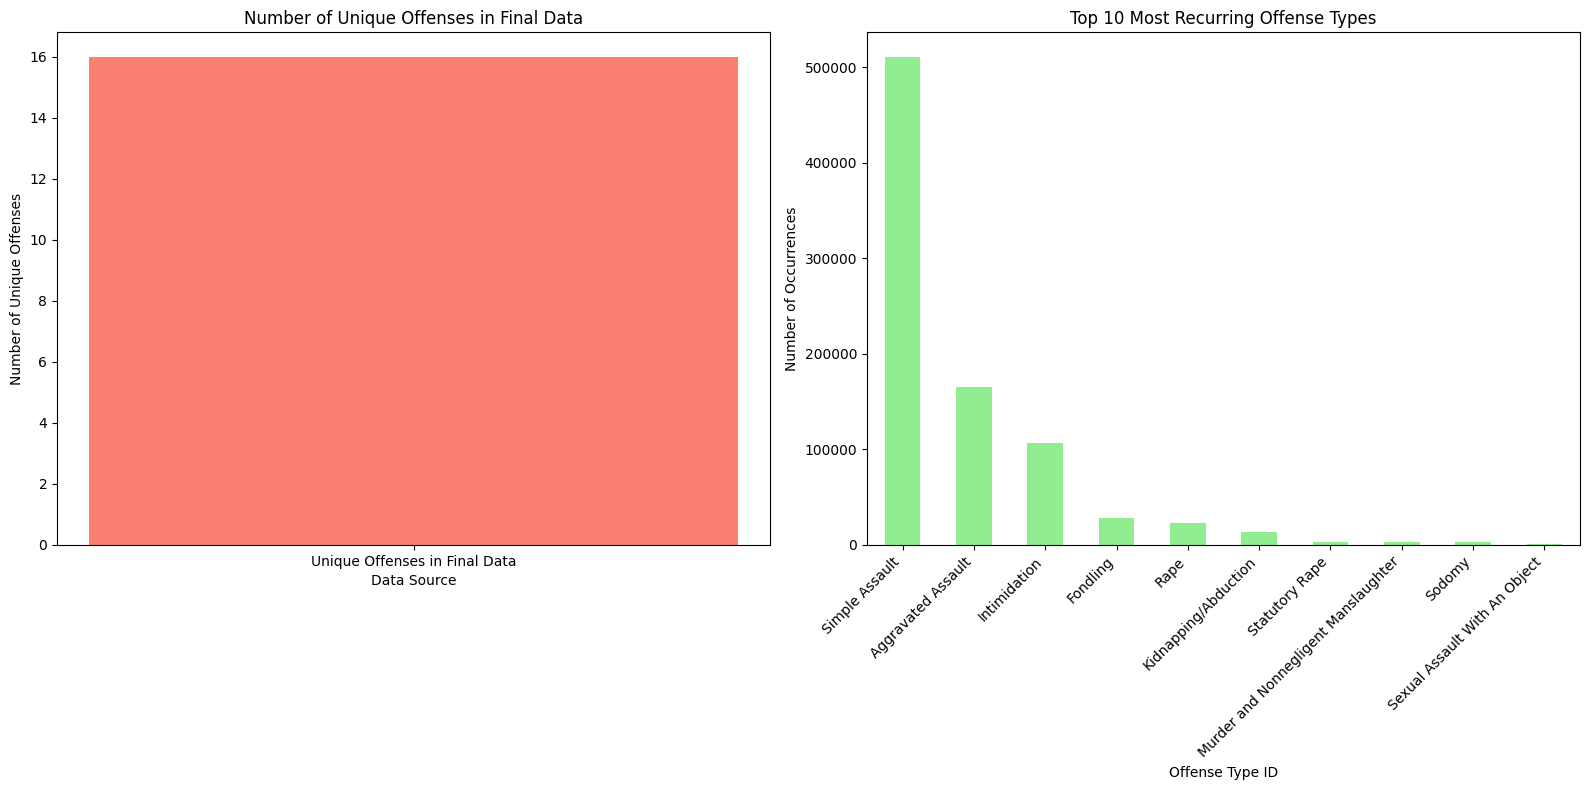

In [20]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append(os.path.abspath("../plots_helper/"))

from FBI_analysis import analyze_offenses

# Define the base directory where Alabama data is stored
base_dir = '../../data/RAW/Washington'
state_prefix = 'WA'

# Analyze and visualize the offenses
analyze_offenses(WA_cleaned_data, base_dir, state_prefix, verbose=False)

The first plot shows that the majority of incidents fall into well-defined and recurring offense categories. It will help us to categorize incidents reliably based on these established classifications

The second plot shows that the top 10 most reccurent violent offense.